In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
tf.reset_default_graph()
batch_size = 64
n_noise = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

In [19]:
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x

In [20]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())

('the loop is:', 0)
(0, 0.554248, 1.1225379, 0.7106545, 0.39784136)
not training discriminator


('the loop is:', 1)
('the loop is:', 2)
('the loop is:', 3)
('the loop is:', 4)
('the loop is:', 5)
('the loop is:', 6)
('the loop is:', 7)
('the loop is:', 8)
('the loop is:', 9)
('the loop is:', 10)
('the loop is:', 11)
('the loop is:', 12)
('the loop is:', 13)
('the loop is:', 14)
('the loop is:', 15)
('the loop is:', 16)
('the loop is:', 17)
('the loop is:', 18)
('the loop is:', 19)
('the loop is:', 20)
('the loop is:', 21)
('the loop is:', 22)
('the loop is:', 23)
('the loop is:', 24)
('the loop is:', 25)
('the loop is:', 26)
('the loop is:', 27)
('the loop is:', 28)
('the loop is:', 29)
('the loop is:', 30)
('the loop is:', 31)
('the loop is:', 32)
('the loop is:', 33)
('the loop is:', 34)
('the loop is:', 35)
('the loop is:', 36)
('the loop is:', 37)
('the loop is:', 38)
('the loop is:', 39)
('the loop is:', 40)
('the loop is:', 41)
('the loop is:', 42)
('the loop is:', 43)
('the loop is:', 44)
('the loop is:', 45)
('the loop is:', 46)
('the loop is:', 47)
('the loop is:', 48)
(

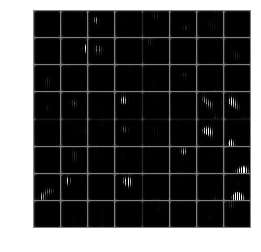

('the loop is:', 51)
('the loop is:', 52)
('the loop is:', 53)
('the loop is:', 54)
('the loop is:', 55)
('the loop is:', 56)
('the loop is:', 57)
('the loop is:', 58)
('the loop is:', 59)
('the loop is:', 60)
('the loop is:', 61)
('the loop is:', 62)
('the loop is:', 63)
('the loop is:', 64)
('the loop is:', 65)
('the loop is:', 66)
('the loop is:', 67)
('the loop is:', 68)
('the loop is:', 69)
('the loop is:', 70)
('the loop is:', 71)
('the loop is:', 72)
('the loop is:', 73)
('the loop is:', 74)
('the loop is:', 75)
('the loop is:', 76)
('the loop is:', 77)
('the loop is:', 78)
('the loop is:', 79)
('the loop is:', 80)
('the loop is:', 81)
('the loop is:', 82)
('the loop is:', 83)
('the loop is:', 84)
('the loop is:', 85)
('the loop is:', 86)
('the loop is:', 87)
('the loop is:', 88)
('the loop is:', 89)
('the loop is:', 90)
('the loop is:', 91)
('the loop is:', 92)
('the loop is:', 93)
('the loop is:', 94)
('the loop is:', 95)
('the loop is:', 96)
('the loop is:', 97)
('the loop is

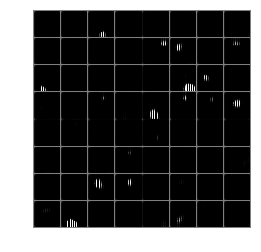

('the loop is:', 101)
('the loop is:', 102)
('the loop is:', 103)
('the loop is:', 104)
('the loop is:', 105)
('the loop is:', 106)
('the loop is:', 107)
('the loop is:', 108)
('the loop is:', 109)
('the loop is:', 110)
('the loop is:', 111)
('the loop is:', 112)
('the loop is:', 113)
('the loop is:', 114)
('the loop is:', 115)
('the loop is:', 116)
('the loop is:', 117)
('the loop is:', 118)
('the loop is:', 119)
('the loop is:', 120)
('the loop is:', 121)
('the loop is:', 122)
('the loop is:', 123)
('the loop is:', 124)
('the loop is:', 125)
('the loop is:', 126)
('the loop is:', 127)
('the loop is:', 128)
('the loop is:', 129)
('the loop is:', 130)
('the loop is:', 131)
('the loop is:', 132)
('the loop is:', 133)
('the loop is:', 134)
('the loop is:', 135)
('the loop is:', 136)
('the loop is:', 137)
('the loop is:', 138)
('the loop is:', 139)
('the loop is:', 140)
('the loop is:', 141)
('the loop is:', 142)
('the loop is:', 143)
('the loop is:', 144)
('the loop is:', 145)
('the loop

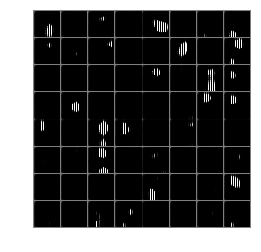

('the loop is:', 151)
('the loop is:', 152)
('the loop is:', 153)
('the loop is:', 154)
('the loop is:', 155)
('the loop is:', 156)
('the loop is:', 157)
('the loop is:', 158)
('the loop is:', 159)
('the loop is:', 160)
('the loop is:', 161)
('the loop is:', 162)
('the loop is:', 163)
('the loop is:', 164)
('the loop is:', 165)
('the loop is:', 166)
('the loop is:', 167)
('the loop is:', 168)
('the loop is:', 169)
('the loop is:', 170)
('the loop is:', 171)
('the loop is:', 172)
('the loop is:', 173)
('the loop is:', 174)
('the loop is:', 175)
('the loop is:', 176)
('the loop is:', 177)
('the loop is:', 178)
('the loop is:', 179)
('the loop is:', 180)
('the loop is:', 181)
('the loop is:', 182)
('the loop is:', 183)
('the loop is:', 184)
('the loop is:', 185)
('the loop is:', 186)
('the loop is:', 187)
('the loop is:', 188)
('the loop is:', 189)
('the loop is:', 190)
('the loop is:', 191)
('the loop is:', 192)
('the loop is:', 193)
('the loop is:', 194)
('the loop is:', 195)
('the loop

('the loop is:', 201)
('the loop is:', 202)
('the loop is:', 203)
('the loop is:', 204)
('the loop is:', 205)
('the loop is:', 206)
('the loop is:', 207)
('the loop is:', 208)
('the loop is:', 209)
('the loop is:', 210)
('the loop is:', 211)
('the loop is:', 212)
('the loop is:', 213)
('the loop is:', 214)
('the loop is:', 215)
('the loop is:', 216)
('the loop is:', 217)
('the loop is:', 218)
('the loop is:', 219)
('the loop is:', 220)
('the loop is:', 221)
('the loop is:', 222)
('the loop is:', 223)
('the loop is:', 224)
('the loop is:', 225)
('the loop is:', 226)
('the loop is:', 227)
('the loop is:', 228)
('the loop is:', 229)
('the loop is:', 230)
('the loop is:', 231)
('the loop is:', 232)
('the loop is:', 233)
('the loop is:', 234)
('the loop is:', 235)
('the loop is:', 236)
('the loop is:', 237)
('the loop is:', 238)
('the loop is:', 239)
('the loop is:', 240)
('the loop is:', 241)
('the loop is:', 242)
('the loop is:', 243)
('the loop is:', 244)
('the loop is:', 245)
('the loop

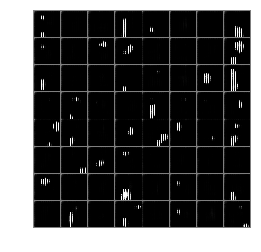

('the loop is:', 251)
('the loop is:', 252)
('the loop is:', 253)
('the loop is:', 254)
('the loop is:', 255)
('the loop is:', 256)
('the loop is:', 257)
('the loop is:', 258)
('the loop is:', 259)
('the loop is:', 260)
('the loop is:', 261)
('the loop is:', 262)
('the loop is:', 263)
('the loop is:', 264)
('the loop is:', 265)
('the loop is:', 266)
('the loop is:', 267)
('the loop is:', 268)
('the loop is:', 269)
('the loop is:', 270)
('the loop is:', 271)
('the loop is:', 272)
('the loop is:', 273)
('the loop is:', 274)
('the loop is:', 275)
('the loop is:', 276)
('the loop is:', 277)
('the loop is:', 278)
('the loop is:', 279)
('the loop is:', 280)
('the loop is:', 281)
('the loop is:', 282)
('the loop is:', 283)
('the loop is:', 284)
('the loop is:', 285)
('the loop is:', 286)
('the loop is:', 287)
('the loop is:', 288)
('the loop is:', 289)
('the loop is:', 290)
('the loop is:', 291)
('the loop is:', 292)
('the loop is:', 293)
('the loop is:', 294)
('the loop is:', 295)
('the loop

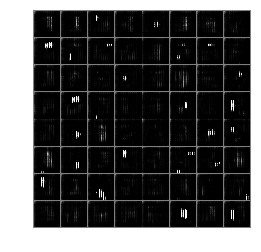

('the loop is:', 301)
('the loop is:', 302)
('the loop is:', 303)
('the loop is:', 304)
('the loop is:', 305)
('the loop is:', 306)
('the loop is:', 307)
('the loop is:', 308)
('the loop is:', 309)
('the loop is:', 310)
('the loop is:', 311)
('the loop is:', 312)
('the loop is:', 313)
('the loop is:', 314)
('the loop is:', 315)
('the loop is:', 316)
('the loop is:', 317)
('the loop is:', 318)
('the loop is:', 319)
('the loop is:', 320)
('the loop is:', 321)
('the loop is:', 322)
('the loop is:', 323)
('the loop is:', 324)
('the loop is:', 325)
('the loop is:', 326)
('the loop is:', 327)
('the loop is:', 328)
('the loop is:', 329)
('the loop is:', 330)
('the loop is:', 331)
('the loop is:', 332)
('the loop is:', 333)
('the loop is:', 334)
('the loop is:', 335)
('the loop is:', 336)
('the loop is:', 337)
('the loop is:', 338)
('the loop is:', 339)
('the loop is:', 340)
('the loop is:', 341)
('the loop is:', 342)
('the loop is:', 343)
('the loop is:', 344)
('the loop is:', 345)
('the loop

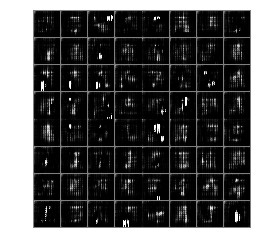

('the loop is:', 351)
('the loop is:', 352)
('the loop is:', 353)
('the loop is:', 354)
('the loop is:', 355)
('the loop is:', 356)
('the loop is:', 357)
('the loop is:', 358)
('the loop is:', 359)
('the loop is:', 360)
('the loop is:', 361)
('the loop is:', 362)
('the loop is:', 363)
('the loop is:', 364)
('the loop is:', 365)
('the loop is:', 366)
('the loop is:', 367)
('the loop is:', 368)
('the loop is:', 369)
('the loop is:', 370)
('the loop is:', 371)
('the loop is:', 372)
('the loop is:', 373)
('the loop is:', 374)
('the loop is:', 375)
('the loop is:', 376)
('the loop is:', 377)
('the loop is:', 378)
('the loop is:', 379)
('the loop is:', 380)
('the loop is:', 381)
('the loop is:', 382)
('the loop is:', 383)
('the loop is:', 384)
('the loop is:', 385)
('the loop is:', 386)
('the loop is:', 387)
('the loop is:', 388)
('the loop is:', 389)
('the loop is:', 390)
('the loop is:', 391)
('the loop is:', 392)
('the loop is:', 393)
('the loop is:', 394)
('the loop is:', 395)
('the loop

('the loop is:', 401)
('the loop is:', 402)
('the loop is:', 403)
('the loop is:', 404)
('the loop is:', 405)
('the loop is:', 406)
('the loop is:', 407)
('the loop is:', 408)
('the loop is:', 409)
('the loop is:', 410)
('the loop is:', 411)
('the loop is:', 412)
('the loop is:', 413)
('the loop is:', 414)
('the loop is:', 415)
('the loop is:', 416)
('the loop is:', 417)
('the loop is:', 418)
('the loop is:', 419)
('the loop is:', 420)
('the loop is:', 421)
('the loop is:', 422)
('the loop is:', 423)
('the loop is:', 424)
('the loop is:', 425)
('the loop is:', 426)
('the loop is:', 427)
('the loop is:', 428)
('the loop is:', 429)
('the loop is:', 430)
('the loop is:', 431)
('the loop is:', 432)
('the loop is:', 433)
('the loop is:', 434)
('the loop is:', 435)
('the loop is:', 436)
('the loop is:', 437)
('the loop is:', 438)
('the loop is:', 439)
('the loop is:', 440)
('the loop is:', 441)
('the loop is:', 442)
('the loop is:', 443)
('the loop is:', 444)
('the loop is:', 445)
('the loop

('the loop is:', 451)
('the loop is:', 452)
('the loop is:', 453)
('the loop is:', 454)
('the loop is:', 455)
('the loop is:', 456)
('the loop is:', 457)
('the loop is:', 458)
('the loop is:', 459)
('the loop is:', 460)
('the loop is:', 461)
('the loop is:', 462)
('the loop is:', 463)
('the loop is:', 464)
('the loop is:', 465)
('the loop is:', 466)
('the loop is:', 467)
('the loop is:', 468)
('the loop is:', 469)
('the loop is:', 470)
('the loop is:', 471)
('the loop is:', 472)
('the loop is:', 473)
('the loop is:', 474)
('the loop is:', 475)
('the loop is:', 476)
('the loop is:', 477)
('the loop is:', 478)
('the loop is:', 479)
('the loop is:', 480)
('the loop is:', 481)
('the loop is:', 482)
('the loop is:', 483)
('the loop is:', 484)
('the loop is:', 485)
('the loop is:', 486)
('the loop is:', 487)
('the loop is:', 488)
('the loop is:', 489)
('the loop is:', 490)
('the loop is:', 491)
('the loop is:', 492)
('the loop is:', 493)
('the loop is:', 494)
('the loop is:', 495)
('the loop

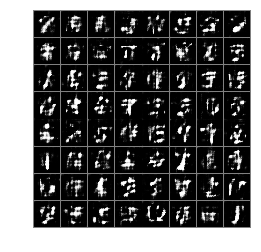

('the loop is:', 501)
('the loop is:', 502)
('the loop is:', 503)
('the loop is:', 504)
('the loop is:', 505)
('the loop is:', 506)
('the loop is:', 507)
('the loop is:', 508)
('the loop is:', 509)
('the loop is:', 510)
('the loop is:', 511)
('the loop is:', 512)
('the loop is:', 513)
('the loop is:', 514)
('the loop is:', 515)
('the loop is:', 516)
('the loop is:', 517)
('the loop is:', 518)
('the loop is:', 519)
('the loop is:', 520)
('the loop is:', 521)
('the loop is:', 522)
('the loop is:', 523)
('the loop is:', 524)
('the loop is:', 525)
('the loop is:', 526)
('the loop is:', 527)
('the loop is:', 528)
('the loop is:', 529)
('the loop is:', 530)
('the loop is:', 531)
('the loop is:', 532)
('the loop is:', 533)
('the loop is:', 534)
('the loop is:', 535)
('the loop is:', 536)
('the loop is:', 537)
('the loop is:', 538)
('the loop is:', 539)
('the loop is:', 540)
('the loop is:', 541)
('the loop is:', 542)
('the loop is:', 543)
('the loop is:', 544)
('the loop is:', 545)
('the loop

('the loop is:', 551)
('the loop is:', 552)
('the loop is:', 553)
('the loop is:', 554)
('the loop is:', 555)
('the loop is:', 556)
('the loop is:', 557)
('the loop is:', 558)
('the loop is:', 559)
('the loop is:', 560)
('the loop is:', 561)
('the loop is:', 562)
('the loop is:', 563)
('the loop is:', 564)
('the loop is:', 565)
('the loop is:', 566)
('the loop is:', 567)
('the loop is:', 568)
('the loop is:', 569)
('the loop is:', 570)
('the loop is:', 571)
('the loop is:', 572)
('the loop is:', 573)
('the loop is:', 574)
('the loop is:', 575)
('the loop is:', 576)
('the loop is:', 577)
('the loop is:', 578)
('the loop is:', 579)
('the loop is:', 580)
('the loop is:', 581)
('the loop is:', 582)
('the loop is:', 583)
('the loop is:', 584)
('the loop is:', 585)
('the loop is:', 586)
('the loop is:', 587)
('the loop is:', 588)
('the loop is:', 589)
('the loop is:', 590)
('the loop is:', 591)
('the loop is:', 592)
('the loop is:', 593)
('the loop is:', 594)
('the loop is:', 595)
('the loop

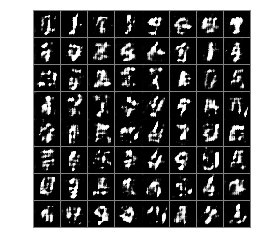

('the loop is:', 601)
('the loop is:', 602)
('the loop is:', 603)
('the loop is:', 604)
('the loop is:', 605)
('the loop is:', 606)
('the loop is:', 607)
('the loop is:', 608)
('the loop is:', 609)
('the loop is:', 610)
('the loop is:', 611)
('the loop is:', 612)
('the loop is:', 613)
('the loop is:', 614)
('the loop is:', 615)
('the loop is:', 616)
('the loop is:', 617)
('the loop is:', 618)
('the loop is:', 619)
('the loop is:', 620)
('the loop is:', 621)
('the loop is:', 622)
('the loop is:', 623)
('the loop is:', 624)
('the loop is:', 625)
('the loop is:', 626)
('the loop is:', 627)
('the loop is:', 628)
('the loop is:', 629)
('the loop is:', 630)
('the loop is:', 631)
('the loop is:', 632)
('the loop is:', 633)
('the loop is:', 634)
('the loop is:', 635)
('the loop is:', 636)
('the loop is:', 637)
('the loop is:', 638)
('the loop is:', 639)
('the loop is:', 640)
('the loop is:', 641)
('the loop is:', 642)
('the loop is:', 643)
('the loop is:', 644)
('the loop is:', 645)
('the loop

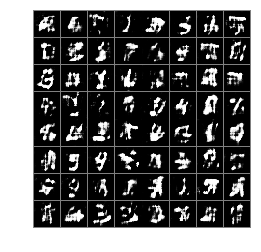

('the loop is:', 651)
('the loop is:', 652)
('the loop is:', 653)
('the loop is:', 654)
('the loop is:', 655)
('the loop is:', 656)
('the loop is:', 657)
('the loop is:', 658)
('the loop is:', 659)
('the loop is:', 660)
('the loop is:', 661)
('the loop is:', 662)
('the loop is:', 663)
('the loop is:', 664)
('the loop is:', 665)
('the loop is:', 666)
('the loop is:', 667)
('the loop is:', 668)
('the loop is:', 669)
('the loop is:', 670)
('the loop is:', 671)
('the loop is:', 672)
('the loop is:', 673)
('the loop is:', 674)
('the loop is:', 675)
('the loop is:', 676)
('the loop is:', 677)
('the loop is:', 678)
('the loop is:', 679)
('the loop is:', 680)
('the loop is:', 681)
('the loop is:', 682)
('the loop is:', 683)
('the loop is:', 684)
('the loop is:', 685)
('the loop is:', 686)
('the loop is:', 687)
('the loop is:', 688)
('the loop is:', 689)
('the loop is:', 690)
('the loop is:', 691)
('the loop is:', 692)
('the loop is:', 693)
('the loop is:', 694)
('the loop is:', 695)
('the loop

('the loop is:', 701)
('the loop is:', 702)
('the loop is:', 703)
('the loop is:', 704)
('the loop is:', 705)
('the loop is:', 706)
('the loop is:', 707)
('the loop is:', 708)
('the loop is:', 709)
('the loop is:', 710)
('the loop is:', 711)
('the loop is:', 712)
('the loop is:', 713)
('the loop is:', 714)
('the loop is:', 715)
('the loop is:', 716)
('the loop is:', 717)
('the loop is:', 718)
('the loop is:', 719)
('the loop is:', 720)
('the loop is:', 721)
('the loop is:', 722)
('the loop is:', 723)
('the loop is:', 724)
('the loop is:', 725)
('the loop is:', 726)
('the loop is:', 727)
('the loop is:', 728)
('the loop is:', 729)
('the loop is:', 730)
('the loop is:', 731)
('the loop is:', 732)
('the loop is:', 733)
('the loop is:', 734)
('the loop is:', 735)
('the loop is:', 736)
('the loop is:', 737)
('the loop is:', 738)
('the loop is:', 739)
('the loop is:', 740)
('the loop is:', 741)
('the loop is:', 742)
('the loop is:', 743)
('the loop is:', 744)
('the loop is:', 745)
('the loop

('the loop is:', 751)
('the loop is:', 752)
('the loop is:', 753)
('the loop is:', 754)
('the loop is:', 755)
('the loop is:', 756)
('the loop is:', 757)
('the loop is:', 758)
('the loop is:', 759)
('the loop is:', 760)
('the loop is:', 761)
('the loop is:', 762)
('the loop is:', 763)
('the loop is:', 764)
('the loop is:', 765)
('the loop is:', 766)
('the loop is:', 767)
('the loop is:', 768)
('the loop is:', 769)
('the loop is:', 770)
('the loop is:', 771)
('the loop is:', 772)
('the loop is:', 773)
('the loop is:', 774)
('the loop is:', 775)
('the loop is:', 776)
('the loop is:', 777)
('the loop is:', 778)
('the loop is:', 779)
('the loop is:', 780)
('the loop is:', 781)
('the loop is:', 782)
('the loop is:', 783)
('the loop is:', 784)
('the loop is:', 785)
('the loop is:', 786)
('the loop is:', 787)
('the loop is:', 788)
('the loop is:', 789)
('the loop is:', 790)
('the loop is:', 791)
('the loop is:', 792)
('the loop is:', 793)
('the loop is:', 794)
('the loop is:', 795)
('the loop

('the loop is:', 801)
('the loop is:', 802)
('the loop is:', 803)
('the loop is:', 804)
('the loop is:', 805)
('the loop is:', 806)
('the loop is:', 807)
('the loop is:', 808)
('the loop is:', 809)
('the loop is:', 810)
('the loop is:', 811)
('the loop is:', 812)
('the loop is:', 813)
('the loop is:', 814)
('the loop is:', 815)
('the loop is:', 816)
('the loop is:', 817)
('the loop is:', 818)
('the loop is:', 819)
('the loop is:', 820)
('the loop is:', 821)
('the loop is:', 822)
('the loop is:', 823)
('the loop is:', 824)
('the loop is:', 825)
('the loop is:', 826)
('the loop is:', 827)
('the loop is:', 828)
('the loop is:', 829)
('the loop is:', 830)
('the loop is:', 831)
('the loop is:', 832)
('the loop is:', 833)
('the loop is:', 834)
('the loop is:', 835)
('the loop is:', 836)
('the loop is:', 837)
('the loop is:', 838)
('the loop is:', 839)
('the loop is:', 840)
('the loop is:', 841)
('the loop is:', 842)
('the loop is:', 843)
('the loop is:', 844)
('the loop is:', 845)
('the loop

('the loop is:', 851)
('the loop is:', 852)
('the loop is:', 853)
('the loop is:', 854)
('the loop is:', 855)
('the loop is:', 856)
('the loop is:', 857)
('the loop is:', 858)
('the loop is:', 859)
('the loop is:', 860)
('the loop is:', 861)
('the loop is:', 862)
('the loop is:', 863)
('the loop is:', 864)
('the loop is:', 865)
('the loop is:', 866)
('the loop is:', 867)
('the loop is:', 868)
('the loop is:', 869)
('the loop is:', 870)
('the loop is:', 871)
('the loop is:', 872)
('the loop is:', 873)
('the loop is:', 874)
('the loop is:', 875)
('the loop is:', 876)
('the loop is:', 877)
('the loop is:', 878)
('the loop is:', 879)
('the loop is:', 880)
('the loop is:', 881)
('the loop is:', 882)
('the loop is:', 883)
('the loop is:', 884)
('the loop is:', 885)
('the loop is:', 886)
('the loop is:', 887)
('the loop is:', 888)
('the loop is:', 889)
('the loop is:', 890)
('the loop is:', 891)
('the loop is:', 892)
('the loop is:', 893)
('the loop is:', 894)
('the loop is:', 895)
('the loop

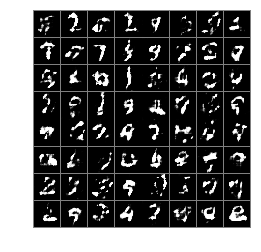

('the loop is:', 901)
('the loop is:', 902)
('the loop is:', 903)
('the loop is:', 904)
('the loop is:', 905)
('the loop is:', 906)
('the loop is:', 907)
('the loop is:', 908)
('the loop is:', 909)
('the loop is:', 910)
('the loop is:', 911)
('the loop is:', 912)
('the loop is:', 913)
('the loop is:', 914)
('the loop is:', 915)
('the loop is:', 916)
('the loop is:', 917)
('the loop is:', 918)
('the loop is:', 919)
('the loop is:', 920)
('the loop is:', 921)
('the loop is:', 922)
('the loop is:', 923)
('the loop is:', 924)
('the loop is:', 925)
('the loop is:', 926)
('the loop is:', 927)
('the loop is:', 928)
('the loop is:', 929)
('the loop is:', 930)
('the loop is:', 931)
('the loop is:', 932)
('the loop is:', 933)
('the loop is:', 934)
('the loop is:', 935)
('the loop is:', 936)
('the loop is:', 937)
('the loop is:', 938)
('the loop is:', 939)
('the loop is:', 940)
('the loop is:', 941)
('the loop is:', 942)
('the loop is:', 943)
('the loop is:', 944)
('the loop is:', 945)
('the loop

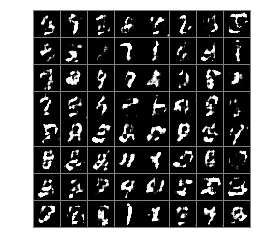

('the loop is:', 951)
('the loop is:', 952)
('the loop is:', 953)
('the loop is:', 954)
('the loop is:', 955)
('the loop is:', 956)
('the loop is:', 957)
('the loop is:', 958)
('the loop is:', 959)
('the loop is:', 960)
('the loop is:', 961)
('the loop is:', 962)
('the loop is:', 963)
('the loop is:', 964)
('the loop is:', 965)
('the loop is:', 966)
('the loop is:', 967)
('the loop is:', 968)
('the loop is:', 969)
('the loop is:', 970)
('the loop is:', 971)
('the loop is:', 972)
('the loop is:', 973)
('the loop is:', 974)
('the loop is:', 975)
('the loop is:', 976)
('the loop is:', 977)
('the loop is:', 978)
('the loop is:', 979)
('the loop is:', 980)
('the loop is:', 981)
('the loop is:', 982)
('the loop is:', 983)
('the loop is:', 984)
('the loop is:', 985)
('the loop is:', 986)
('the loop is:', 987)
('the loop is:', 988)
('the loop is:', 989)
('the loop is:', 990)
('the loop is:', 991)
('the loop is:', 992)
('the loop is:', 993)
('the loop is:', 994)
('the loop is:', 995)
('the loop

('the loop is:', 1001)
('the loop is:', 1002)
('the loop is:', 1003)
('the loop is:', 1004)
('the loop is:', 1005)
('the loop is:', 1006)
('the loop is:', 1007)
('the loop is:', 1008)
('the loop is:', 1009)
('the loop is:', 1010)
('the loop is:', 1011)
('the loop is:', 1012)
('the loop is:', 1013)
('the loop is:', 1014)
('the loop is:', 1015)
('the loop is:', 1016)
('the loop is:', 1017)
('the loop is:', 1018)
('the loop is:', 1019)
('the loop is:', 1020)
('the loop is:', 1021)
('the loop is:', 1022)
('the loop is:', 1023)
('the loop is:', 1024)
('the loop is:', 1025)
('the loop is:', 1026)
('the loop is:', 1027)
('the loop is:', 1028)
('the loop is:', 1033)
('the loop is:', 1034)
('the loop is:', 1035)
('the loop is:', 1036)
('the loop is:', 1037)
('the loop is:', 1038)
('the loop is:', 1039)
('the loop is:', 1040)
('the loop is:', 1041)
('the loop is:', 1042)
('the loop is:', 1043)
('the loop is:', 1044)
('the loop is:', 1045)
('the loop is:', 1046)
('the loop is:', 1047)
('the loop 

('the loop is:', 1051)
('the loop is:', 1052)
('the loop is:', 1053)
('the loop is:', 1054)
('the loop is:', 1055)
('the loop is:', 1056)
('the loop is:', 1057)
('the loop is:', 1058)
('the loop is:', 1059)
('the loop is:', 1060)
('the loop is:', 1061)
('the loop is:', 1062)
('the loop is:', 1063)
('the loop is:', 1064)
('the loop is:', 1065)
('the loop is:', 1066)
('the loop is:', 1067)
('the loop is:', 1068)
('the loop is:', 1069)
('the loop is:', 1070)
('the loop is:', 1071)
('the loop is:', 1072)
('the loop is:', 1073)
('the loop is:', 1074)
('the loop is:', 1075)
('the loop is:', 1076)
('the loop is:', 1077)
('the loop is:', 1078)
('the loop is:', 1079)
('the loop is:', 1080)
('the loop is:', 1081)
('the loop is:', 1082)
('the loop is:', 1083)
('the loop is:', 1084)
('the loop is:', 1085)
('the loop is:', 1086)
('the loop is:', 1087)
('the loop is:', 1088)
('the loop is:', 1089)
('the loop is:', 1090)
('the loop is:', 1091)
('the loop is:', 1092)
('the loop is:', 1093)
('the loop 

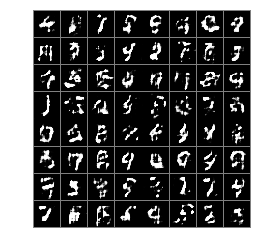

('the loop is:', 1101)
('the loop is:', 1102)
('the loop is:', 1103)
('the loop is:', 1104)
('the loop is:', 1105)
('the loop is:', 1106)
('the loop is:', 1107)
('the loop is:', 1108)
('the loop is:', 1109)
('the loop is:', 1110)
('the loop is:', 1111)
('the loop is:', 1112)
('the loop is:', 1113)
('the loop is:', 1114)
('the loop is:', 1115)
('the loop is:', 1116)
('the loop is:', 1117)
('the loop is:', 1118)
('the loop is:', 1119)
('the loop is:', 1120)
('the loop is:', 1121)
('the loop is:', 1122)
('the loop is:', 1123)
('the loop is:', 1124)
('the loop is:', 1125)
('the loop is:', 1126)
('the loop is:', 1127)
('the loop is:', 1128)
('the loop is:', 1129)
('the loop is:', 1130)
('the loop is:', 1131)
('the loop is:', 1132)
('the loop is:', 1133)
('the loop is:', 1134)
('the loop is:', 1135)
('the loop is:', 1136)
('the loop is:', 1137)
('the loop is:', 1138)
('the loop is:', 1139)
('the loop is:', 1140)
('the loop is:', 1141)
('the loop is:', 1142)
('the loop is:', 1143)
('the loop 

('the loop is:', 1151)
('the loop is:', 1152)
('the loop is:', 1153)
('the loop is:', 1154)
('the loop is:', 1155)
('the loop is:', 1156)
('the loop is:', 1157)
('the loop is:', 1158)
('the loop is:', 1159)
('the loop is:', 1160)
('the loop is:', 1161)
('the loop is:', 1162)
('the loop is:', 1163)
('the loop is:', 1164)
('the loop is:', 1165)
('the loop is:', 1166)
('the loop is:', 1167)
('the loop is:', 1168)
('the loop is:', 1169)
('the loop is:', 1170)
('the loop is:', 1171)
('the loop is:', 1172)
('the loop is:', 1173)
('the loop is:', 1174)
('the loop is:', 1175)
('the loop is:', 1176)
('the loop is:', 1177)
('the loop is:', 1178)
('the loop is:', 1179)
('the loop is:', 1180)
('the loop is:', 1181)
('the loop is:', 1182)
('the loop is:', 1183)
('the loop is:', 1184)
('the loop is:', 1185)
('the loop is:', 1186)
('the loop is:', 1187)
('the loop is:', 1188)
('the loop is:', 1189)
('the loop is:', 1190)
('the loop is:', 1191)
('the loop is:', 1192)
('the loop is:', 1193)
('the loop 

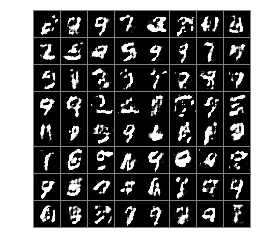

('the loop is:', 1201)
('the loop is:', 1202)
('the loop is:', 1203)
('the loop is:', 1204)
('the loop is:', 1205)
('the loop is:', 1206)
('the loop is:', 1207)
('the loop is:', 1208)
('the loop is:', 1209)
('the loop is:', 1210)
('the loop is:', 1211)
('the loop is:', 1212)
('the loop is:', 1213)
('the loop is:', 1214)
('the loop is:', 1215)
('the loop is:', 1216)
('the loop is:', 1217)
('the loop is:', 1218)
('the loop is:', 1219)
('the loop is:', 1220)
('the loop is:', 1221)
('the loop is:', 1222)
('the loop is:', 1223)
('the loop is:', 1224)
('the loop is:', 1225)
('the loop is:', 1226)
('the loop is:', 1227)
('the loop is:', 1228)
('the loop is:', 1229)
('the loop is:', 1230)
('the loop is:', 1231)
('the loop is:', 1232)
('the loop is:', 1233)
('the loop is:', 1234)
('the loop is:', 1235)
('the loop is:', 1236)
('the loop is:', 1237)
('the loop is:', 1238)
('the loop is:', 1239)
('the loop is:', 1240)
('the loop is:', 1241)
('the loop is:', 1242)
('the loop is:', 1243)
('the loop 

('the loop is:', 1251)
('the loop is:', 1252)
('the loop is:', 1253)
('the loop is:', 1254)
('the loop is:', 1255)
('the loop is:', 1256)
('the loop is:', 1257)
('the loop is:', 1258)
('the loop is:', 1259)
('the loop is:', 1260)
('the loop is:', 1261)
('the loop is:', 1262)
('the loop is:', 1263)
('the loop is:', 1264)
('the loop is:', 1265)
('the loop is:', 1266)
('the loop is:', 1267)
('the loop is:', 1268)
('the loop is:', 1269)
('the loop is:', 1270)
('the loop is:', 1271)
('the loop is:', 1272)
('the loop is:', 1273)
('the loop is:', 1274)
('the loop is:', 1275)
('the loop is:', 1276)
('the loop is:', 1277)
('the loop is:', 1278)
('the loop is:', 1279)
('the loop is:', 1280)
('the loop is:', 1281)
('the loop is:', 1282)
('the loop is:', 1283)
('the loop is:', 1284)
('the loop is:', 1285)
('the loop is:', 1286)
('the loop is:', 1287)
('the loop is:', 1288)
('the loop is:', 1289)
('the loop is:', 1290)
('the loop is:', 1291)
('the loop is:', 1292)
('the loop is:', 1293)
('the loop 

('the loop is:', 1301)
('the loop is:', 1302)
('the loop is:', 1303)
('the loop is:', 1304)
('the loop is:', 1305)
('the loop is:', 1306)
('the loop is:', 1307)
('the loop is:', 1308)
('the loop is:', 1309)
('the loop is:', 1310)
('the loop is:', 1311)
('the loop is:', 1312)
('the loop is:', 1313)
('the loop is:', 1314)
('the loop is:', 1315)
('the loop is:', 1316)
('the loop is:', 1317)
('the loop is:', 1318)
('the loop is:', 1319)
('the loop is:', 1320)
('the loop is:', 1321)
('the loop is:', 1322)
('the loop is:', 1323)
('the loop is:', 1324)
('the loop is:', 1325)
('the loop is:', 1326)
('the loop is:', 1327)
('the loop is:', 1328)
('the loop is:', 1329)
('the loop is:', 1330)
('the loop is:', 1331)
('the loop is:', 1332)
('the loop is:', 1333)
('the loop is:', 1334)
('the loop is:', 1335)
('the loop is:', 1336)
('the loop is:', 1337)
('the loop is:', 1338)
('the loop is:', 1339)
('the loop is:', 1340)
('the loop is:', 1341)
('the loop is:', 1342)
('the loop is:', 1343)
('the loop 

('the loop is:', 1351)
('the loop is:', 1352)
('the loop is:', 1353)
('the loop is:', 1354)
('the loop is:', 1355)
('the loop is:', 1356)
('the loop is:', 1357)
('the loop is:', 1358)
('the loop is:', 1359)
('the loop is:', 1360)
('the loop is:', 1361)
('the loop is:', 1362)
('the loop is:', 1363)
('the loop is:', 1364)
('the loop is:', 1365)
('the loop is:', 1366)
('the loop is:', 1367)
('the loop is:', 1368)
('the loop is:', 1369)
('the loop is:', 1370)
('the loop is:', 1371)
('the loop is:', 1372)
('the loop is:', 1373)
('the loop is:', 1374)
('the loop is:', 1375)
('the loop is:', 1376)
('the loop is:', 1377)
('the loop is:', 1378)
('the loop is:', 1379)
('the loop is:', 1380)
('the loop is:', 1381)
('the loop is:', 1382)
('the loop is:', 1383)
('the loop is:', 1384)
('the loop is:', 1385)
('the loop is:', 1386)
('the loop is:', 1387)
('the loop is:', 1388)
('the loop is:', 1389)
('the loop is:', 1390)
('the loop is:', 1391)
('the loop is:', 1392)
('the loop is:', 1393)
('the loop 

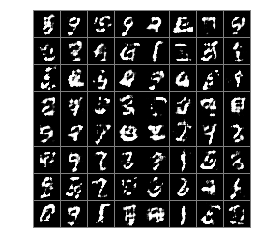

('the loop is:', 1401)
('the loop is:', 1402)
('the loop is:', 1403)
('the loop is:', 1404)
('the loop is:', 1405)
('the loop is:', 1406)
('the loop is:', 1407)
('the loop is:', 1408)
('the loop is:', 1409)
('the loop is:', 1410)
('the loop is:', 1411)
('the loop is:', 1412)
('the loop is:', 1413)
('the loop is:', 1414)
('the loop is:', 1415)
('the loop is:', 1416)
('the loop is:', 1417)
('the loop is:', 1418)
('the loop is:', 1419)
('the loop is:', 1420)
('the loop is:', 1421)
('the loop is:', 1422)
('the loop is:', 1423)
('the loop is:', 1424)
('the loop is:', 1425)
('the loop is:', 1426)
('the loop is:', 1427)
('the loop is:', 1428)
('the loop is:', 1429)
('the loop is:', 1430)
('the loop is:', 1431)
('the loop is:', 1432)
('the loop is:', 1433)
('the loop is:', 1434)
('the loop is:', 1435)
('the loop is:', 1436)
('the loop is:', 1437)
('the loop is:', 1438)
('the loop is:', 1439)
('the loop is:', 1440)
('the loop is:', 1441)
('the loop is:', 1442)
('the loop is:', 1443)
('the loop 

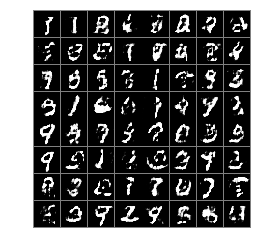

('the loop is:', 1451)
('the loop is:', 1452)
('the loop is:', 1453)
('the loop is:', 1454)
('the loop is:', 1455)
('the loop is:', 1456)
('the loop is:', 1457)
('the loop is:', 1458)
('the loop is:', 1459)
('the loop is:', 1460)
('the loop is:', 1461)
('the loop is:', 1462)
('the loop is:', 1463)
('the loop is:', 1464)
('the loop is:', 1465)
('the loop is:', 1466)
('the loop is:', 1467)
('the loop is:', 1468)
('the loop is:', 1469)
('the loop is:', 1470)
('the loop is:', 1471)
('the loop is:', 1472)
('the loop is:', 1473)
('the loop is:', 1474)
('the loop is:', 1475)
('the loop is:', 1476)
('the loop is:', 1477)
('the loop is:', 1478)
('the loop is:', 1479)
('the loop is:', 1480)
('the loop is:', 1481)
('the loop is:', 1482)
('the loop is:', 1483)
('the loop is:', 1484)
('the loop is:', 1485)
('the loop is:', 1486)
('the loop is:', 1487)
('the loop is:', 1488)
('the loop is:', 1489)
('the loop is:', 1490)
('the loop is:', 1491)
('the loop is:', 1492)
('the loop is:', 1493)
('the loop 

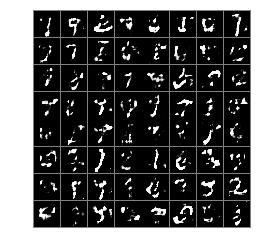

('the loop is:', 1501)
('the loop is:', 1502)
('the loop is:', 1503)
('the loop is:', 1504)
('the loop is:', 1505)
('the loop is:', 1506)
('the loop is:', 1507)
('the loop is:', 1508)
('the loop is:', 1509)
('the loop is:', 1510)
('the loop is:', 1511)
('the loop is:', 1512)
('the loop is:', 1513)
('the loop is:', 1514)
('the loop is:', 1515)
('the loop is:', 1516)
('the loop is:', 1517)
('the loop is:', 1518)
('the loop is:', 1519)
('the loop is:', 1520)
('the loop is:', 1521)
('the loop is:', 1522)
('the loop is:', 1523)
('the loop is:', 1524)
('the loop is:', 1525)
('the loop is:', 1526)
('the loop is:', 1527)
('the loop is:', 1528)
('the loop is:', 1529)
('the loop is:', 1530)
('the loop is:', 1531)
('the loop is:', 1532)
('the loop is:', 1533)
('the loop is:', 1534)
('the loop is:', 1535)
('the loop is:', 1536)
('the loop is:', 1537)
('the loop is:', 1538)
('the loop is:', 1539)
('the loop is:', 1540)
('the loop is:', 1541)
('the loop is:', 1542)
('the loop is:', 1543)
('the loop 

('the loop is:', 1551)
('the loop is:', 1552)
('the loop is:', 1553)
('the loop is:', 1554)
('the loop is:', 1555)
('the loop is:', 1556)
('the loop is:', 1557)
('the loop is:', 1558)
('the loop is:', 1559)
('the loop is:', 1560)
('the loop is:', 1561)
('the loop is:', 1562)
('the loop is:', 1563)
('the loop is:', 1564)
('the loop is:', 1565)
('the loop is:', 1566)
('the loop is:', 1567)
('the loop is:', 1568)
('the loop is:', 1569)
('the loop is:', 1570)
('the loop is:', 1571)
('the loop is:', 1572)
('the loop is:', 1573)
('the loop is:', 1574)
('the loop is:', 1575)
('the loop is:', 1576)
('the loop is:', 1577)
('the loop is:', 1578)
('the loop is:', 1579)
('the loop is:', 1580)
('the loop is:', 1581)
('the loop is:', 1582)
('the loop is:', 1583)
('the loop is:', 1584)
('the loop is:', 1585)
('the loop is:', 1586)
('the loop is:', 1587)
('the loop is:', 1588)
('the loop is:', 1589)
('the loop is:', 1590)
('the loop is:', 1591)
('the loop is:', 1592)
('the loop is:', 1593)
('the loop 

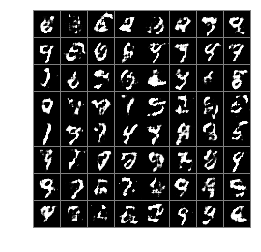

('the loop is:', 1601)
('the loop is:', 1602)
('the loop is:', 1603)
('the loop is:', 1604)
('the loop is:', 1605)
('the loop is:', 1606)
('the loop is:', 1607)
('the loop is:', 1608)
('the loop is:', 1609)
('the loop is:', 1610)
('the loop is:', 1611)
('the loop is:', 1612)
('the loop is:', 1613)
('the loop is:', 1614)
('the loop is:', 1615)
('the loop is:', 1616)
('the loop is:', 1617)
('the loop is:', 1618)
('the loop is:', 1619)
('the loop is:', 1620)
('the loop is:', 1621)
('the loop is:', 1622)
('the loop is:', 1623)
('the loop is:', 1624)
('the loop is:', 1625)
('the loop is:', 1626)
('the loop is:', 1627)
('the loop is:', 1628)
('the loop is:', 1629)
('the loop is:', 1630)
('the loop is:', 1631)
('the loop is:', 1632)
('the loop is:', 1633)
('the loop is:', 1634)
('the loop is:', 1635)
('the loop is:', 1636)
('the loop is:', 1637)
('the loop is:', 1638)
('the loop is:', 1639)
('the loop is:', 1640)
('the loop is:', 1641)
('the loop is:', 1642)
('the loop is:', 1643)
('the loop 

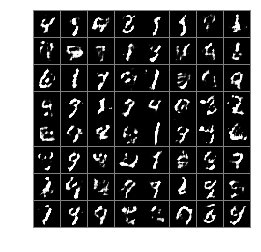

('the loop is:', 1651)
('the loop is:', 1652)
('the loop is:', 1653)
('the loop is:', 1654)
('the loop is:', 1655)
('the loop is:', 1656)
('the loop is:', 1657)
('the loop is:', 1658)
('the loop is:', 1659)
('the loop is:', 1660)
('the loop is:', 1661)
('the loop is:', 1662)
('the loop is:', 1663)
('the loop is:', 1664)
('the loop is:', 1665)
('the loop is:', 1666)
('the loop is:', 1667)
('the loop is:', 1668)
('the loop is:', 1669)
('the loop is:', 1670)
('the loop is:', 1671)
('the loop is:', 1672)
('the loop is:', 1673)
('the loop is:', 1674)
('the loop is:', 1675)
('the loop is:', 1676)
('the loop is:', 1677)
('the loop is:', 1678)
('the loop is:', 1679)
('the loop is:', 1680)
('the loop is:', 1681)
('the loop is:', 1682)
('the loop is:', 1683)
('the loop is:', 1684)
('the loop is:', 1685)
('the loop is:', 1686)
('the loop is:', 1687)
('the loop is:', 1688)
('the loop is:', 1689)
('the loop is:', 1690)
('the loop is:', 1691)
('the loop is:', 1692)
('the loop is:', 1693)
('the loop 

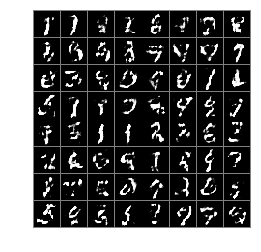

('the loop is:', 1701)
('the loop is:', 1702)
('the loop is:', 1703)
('the loop is:', 1704)
('the loop is:', 1705)
('the loop is:', 1706)
('the loop is:', 1707)
('the loop is:', 1708)
('the loop is:', 1709)
('the loop is:', 1710)
('the loop is:', 1711)
('the loop is:', 1712)
('the loop is:', 1713)
('the loop is:', 1714)
('the loop is:', 1715)
('the loop is:', 1716)
('the loop is:', 1717)
('the loop is:', 1718)
('the loop is:', 1719)
('the loop is:', 1720)
('the loop is:', 1721)
('the loop is:', 1722)
('the loop is:', 1723)
('the loop is:', 1724)
('the loop is:', 1725)
('the loop is:', 1726)
('the loop is:', 1727)
('the loop is:', 1728)
('the loop is:', 1729)
('the loop is:', 1730)
('the loop is:', 1731)
('the loop is:', 1732)
('the loop is:', 1733)
('the loop is:', 1734)
('the loop is:', 1735)
('the loop is:', 1736)
('the loop is:', 1737)
('the loop is:', 1738)
('the loop is:', 1739)
('the loop is:', 1740)
('the loop is:', 1741)
('the loop is:', 1742)
('the loop is:', 1743)
('the loop 

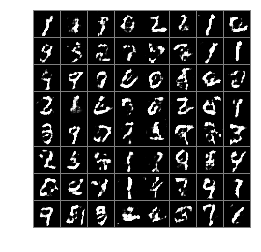

('the loop is:', 1751)
('the loop is:', 1752)
('the loop is:', 1753)
('the loop is:', 1754)
('the loop is:', 1755)
('the loop is:', 1756)
('the loop is:', 1757)
('the loop is:', 1758)
('the loop is:', 1759)
('the loop is:', 1760)
('the loop is:', 1761)
('the loop is:', 1762)
('the loop is:', 1763)
('the loop is:', 1764)
('the loop is:', 1765)


KeyboardInterrupt: 

In [23]:
for i in range(6000):
    print('the loop is:', i)
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 50:
        print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()